In [ ]:
# 코드 실행 후 런타임 재시작

# 한글 시각화
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 분류모델에서 필요한 패키지
!pip install category_encoders 
!pip install xgboost==1.7.2
!pip3 install imbalanced-learn
!pip install eli5
!pip install scikit-learn==1.1.3

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy import stats
from xgboost import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.pipeline import *
from sklearn.impute import *
from eli5.sklearn import *
from sklearn.tree import *
from xgboost import *
from category_encoders import *

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumGothic')
%config InlineBackend.figure_format='retina'

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
attack = pd.read_csv('/content/drive/MyDrive/Codestates/N200/Project/data/attack.csv')

# 데이터 준비

In [4]:
# 선수고유번호, 선수이름은 각 칼럼의 명칭을 의미하므로 제거
# 평가점수는 출시 예정 카드들에게 존재하지 않는 정보이기 때문에 예측에 활용할 수 없으믈 제거
attack.drop(['선수고유번호','선수이름','평가점수'], axis=1, inplace=True)

In [5]:
attack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   신장        13523 non-null  int64
 1   몸무게       13523 non-null  int64
 2   속력        13523 non-null  int64
 3   가속력       13523 non-null  int64
 4   골 결정력     13523 non-null  int64
 5   슛 파워      13523 non-null  int64
 6   중거리 슛     13523 non-null  int64
 7   위치 선정     13523 non-null  int64
 8   발리슛       13523 non-null  int64
 9   패널티 킥     13523 non-null  int64
 10  짧은 패스     13523 non-null  int64
 11  시야        13523 non-null  int64
 12  크로스       13523 non-null  int64
 13  긴 패스      13523 non-null  int64
 14  프리킥       13523 non-null  int64
 15  커브        13523 non-null  int64
 16  드리블       13523 non-null  int64
 17  볼 컨트롤     13523 non-null  int64
 18  민첩성       13523 non-null  int64
 19  밸런스       13523 non-null  int64
 20  반응 속도     13523 non-null  int64
 21  대인 수비     13523 non-null  int64
 22

In [15]:
attack['OP 여부'].value_counts()

0    12959
1      564
Name: OP 여부, dtype: int64

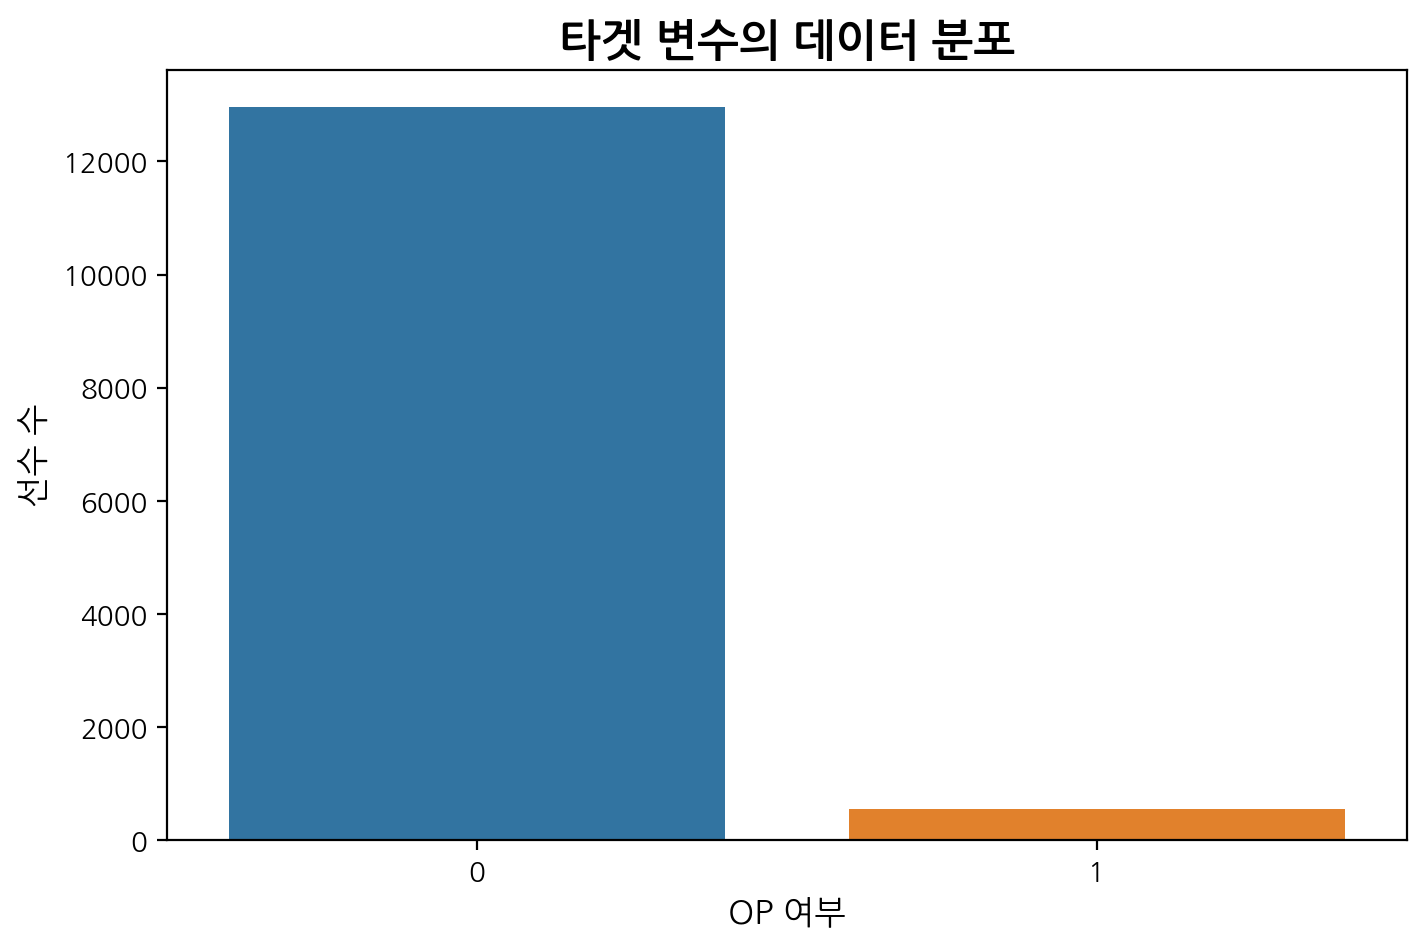

In [17]:
plt.figure(figsize=(8,5))

sns.countplot(x = 'OP 여부', data=attack)
plt.title('타겟 변수의 데이터 분포', fontsize=16, fontweight = 'bold')
plt.ylabel('선수 수', fontsize=12)
plt.xlabel('OP 여부', fontsize=12)
plt.show()

데이터가 불균형한 경우, 분류 모델의 성능 지표 F1-Score를 사용
- 앞서 살펴본 다른 지표를 기준으로 할 경우, 하나의 값으로만 예측하는 모델이 더 좋은 성능을 나타내는 결과가 나타나기도 함

어떤 에러가 치명적인가
- FN : OP 선수를 아니라고 판단한 경우 -> OP 선수가 급여로 인한 패널티를 제대로 받지 않음 -> 밸런스 위험
- FP : OP 선수를 사용한다고 판단한 경우 -> 평범한 카드가 아예 못 쓸 카드가 됨
- FN이 더 심각한 에러 -> 동일한 F1-Score에서는 Recall 값이 더 높은 경우를 선택

In [6]:
# 특성과 타겟 지정
target = 'OP 여부'

X = attack.drop(target, axis=1)
y = attack[target]

In [7]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9466, 37) (9466,)
(4057, 37) (4057,)


In [9]:
y_train.value_counts(normalize=True)

0    0.958272
1    0.041728
Name: OP 여부, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.958344
1    0.041656
Name: OP 여부, dtype: float64

# 기준 모델 : Decision Tree
- 내가 생각하기에 타겟 변수의 불균형을 반영할 수 있는 가장 간단한 모델인 `Decision Tree` 모델을 기준 모델로 선정했다.
- 그 외 파라미터는 모두 `Default` 값으로 선정했다.

In [18]:
# 모델 훈련
base = DecisionTreeClassifier(
    random_state = 42,
    class_weight = 'balanced'
)

base.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [19]:
# 기준 모델의 훈련 성능 확인 
cv_results = cross_val_score(
    base, 
    X_train, 
    y_train, 
    cv=5,
    scoring="f1",
    n_jobs=-1
    )

print('기준 모델 F1 Score : ', np.mean(cv_results).round(2))

기준 모델 F1 Score :  0.6


# 모델 선정
- 타겟 변수 불균형 해소 방식
  - 모델 파라미터

- 사용 모델 
  1. RandomForest
  2. XGBoost

- 모델 선정 방식
  - 위의 두 모델에 대해서 Randomized Search 방식으로 하이퍼 파라미터를 적용하여 더 성능이 좋은 모델 선정
    - Randomized Search 파라미터 : `cv=5, n_iter=10`
    - RandomFroestClassifier의 파라미터
    ```python
    params = {
      "max_depth": [2, 4, 6, 8, 10],
      "min_samples_split": [2, 4, 6, 8],
      "n_estimators": [50, 100, 150, 200]
  }
    ```
    - XGBClassifier의 파라미터
    ```python
    params = {
      "max_depth": [2, 4, 6, 8, 10],
      "learning_rate" : [0.1, 0.15, 0.2, 0.25],
      "min_child_weight": [2, 4, 6, 8]
  }
    ```
  - 이후 성능이 더 좋은 모델에 대해서 추가적으로 Exhausted Grid Search 혹은 직접 튜닝 방식을 적용

## RandomizedSearch

### `RandomForestClassifier`

In [97]:
# 하이퍼파라미터
params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8],
    "n_estimators": [50, 100, 150, 200]
}

In [98]:
# 하이퍼파라미터 튜닝
rf_param = RandomizedSearchCV(
    RandomForestClassifier(
        random_state = 42,
        class_weight='balanced'
    ),
    param_distributions=params,
    scoring='f1',
    n_iter=10,
    cv=5,
    random_state=42
)

rf_param.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='f1')

In [99]:
# 최적 파라미터와 성능
print("최적 하이퍼파라미터: ", rf_param.best_params_)
print("최적 F1 Score: ", rf_param.best_score_)

최적 하이퍼파라미터:  {'n_estimators': 150, 'min_samples_split': 4, 'max_depth': 10}
최적 F1 Score:  0.671213647204898


### `XGBClassifier`

In [20]:
# 타겟변수의 불균형 문제를 반영해주는 파라미터 값
balance = y_train.value_counts()[0]/y_train.value_counts()[1]
balance

22.964556962025316

In [103]:
params = {
    "max_depth": [2, 4, 6, 8, 10],
    "learning_rate" : [0.1, 0.15, 0.2, 0.25],
    "min_child_weight": [2, 4, 6, 8]
}

In [104]:
# 하이퍼파라미터 튜닝
xgb_param = RandomizedSearchCV(
    XGBClassifier(
        random_state = 42,
        scale_pos_weight=balance
    ),
    param_distributions=params,
    scoring='f1',
    n_iter=10,
    cv=5,
    random_state=42
)

xgb_param.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   param_distributions={'learning_rate': [0.1, 0.15, 0.2, 0.25],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'min_child_weight': [2, 4, 6, 8]},
                   random_state=42, scoring='f1')

In [105]:
# 최적 파라미터와 성능
print("최적 하이퍼파라미터: ", xgb_param.best_params_)
print("최적 F1 Score: ", xgb_param.best_score_)

최적 하이퍼파라미터:  {'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
최적 F1 Score:  0.7027716751079025


- `XGBClassifier` 모델의 성능이 더 좋게 나타났다.

## Exhausted Grid Search

### Search 1

In [106]:
# 하이퍼 파라미터
params = {
    "max_depth": [5,6,7,8,9],
    "learning_rate" : [0.05, 0.1, 0.15],
    "min_child_weight": [1,2,3]
}

In [107]:
# 모델 학습
grid_search1 = GridSearchCV(
    XGBClassifier(
        random_state = 42,
        scale_pos_weight=balance
    ),
    param_grid=params, 
    scoring="f1", 
    cv=5
)

grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 6, 7, 8, 9],
                         'min_child_weight': [1, 2, 3]},
             scoring='f1')

In [108]:
# 최적 파라미터 확인
print("최적 하이퍼파라미터: ", grid_search1.best_params_)
print("최적 F1-Score: ", grid_search1.best_score_)

최적 하이퍼파라미터:  {'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 1}
최적 F1-Score:  0.710853152788426


### Search 2

In [109]:
# 하이퍼 파라미터
params = {
    "max_depth": [7, 8, 9],
    "learning_rate" : [0.1, 0.15, 0.2],
    "min_child_weight": [1,2]
}

In [110]:
# 모델 학습
grid_search2 = GridSearchCV(
    XGBClassifier(
        random_state = 42,
        scale_pos_weight=balance
    ),
    param_grid=params, 
    scoring="f1", 
    cv=5
)

grid_search2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [7, 8, 9], 'min_child_weight': [1, 2]},
             scoring='f1')

In [111]:
# 최적 파라미터 확인
print("최적 하이퍼파라미터: ", grid_search2.best_params_)
print("최적 F1-Score: ", grid_search2.best_score_)

최적 하이퍼파라미터:  {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1}
최적 F1-Score:  0.7173271250118008


Search 3

In [112]:
# 하이퍼 파라미터
params = {
    "max_depth": [8, 9, 10],
    "learning_rate" : [0.15, 0.2, 0.25],
    "min_child_weight": [1]
}

In [113]:
# 모델 학습
grid_search3 = GridSearchCV(
    XGBClassifier(
        random_state = 42,
        scale_pos_weight=balance
    ),
    param_grid=params, 
    scoring="f1", 
    cv=5
)

grid_search3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.15, 0.2, 0.25],
                         'max_depth': [8, 9, 10], 'min_child_weight': [1]},
             scoring='f1')

In [114]:
# 최적 파라미터 확인
print("최적 하이퍼파라미터: ", grid_search3.best_params_)
print("최적 F1-Score: ", grid_search3.best_score_)

최적 하이퍼파라미터:  {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1}
최적 F1-Score:  0.7173271250118008


- `Search 2`과 `Search 3`의 결과가 동일하므로, 해당 파라미터를 최종 모델로 선정

# 최종 모델

In [21]:
final = XGBClassifier(
    random_state = 42,
    scale_pos_weight = balance,
    learning_rate = 0.2,
    max_depth = 9,
    min_child_weight=1
)

final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [115]:
# 모델 훈련
final = grid_search3.best_estimator_

final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

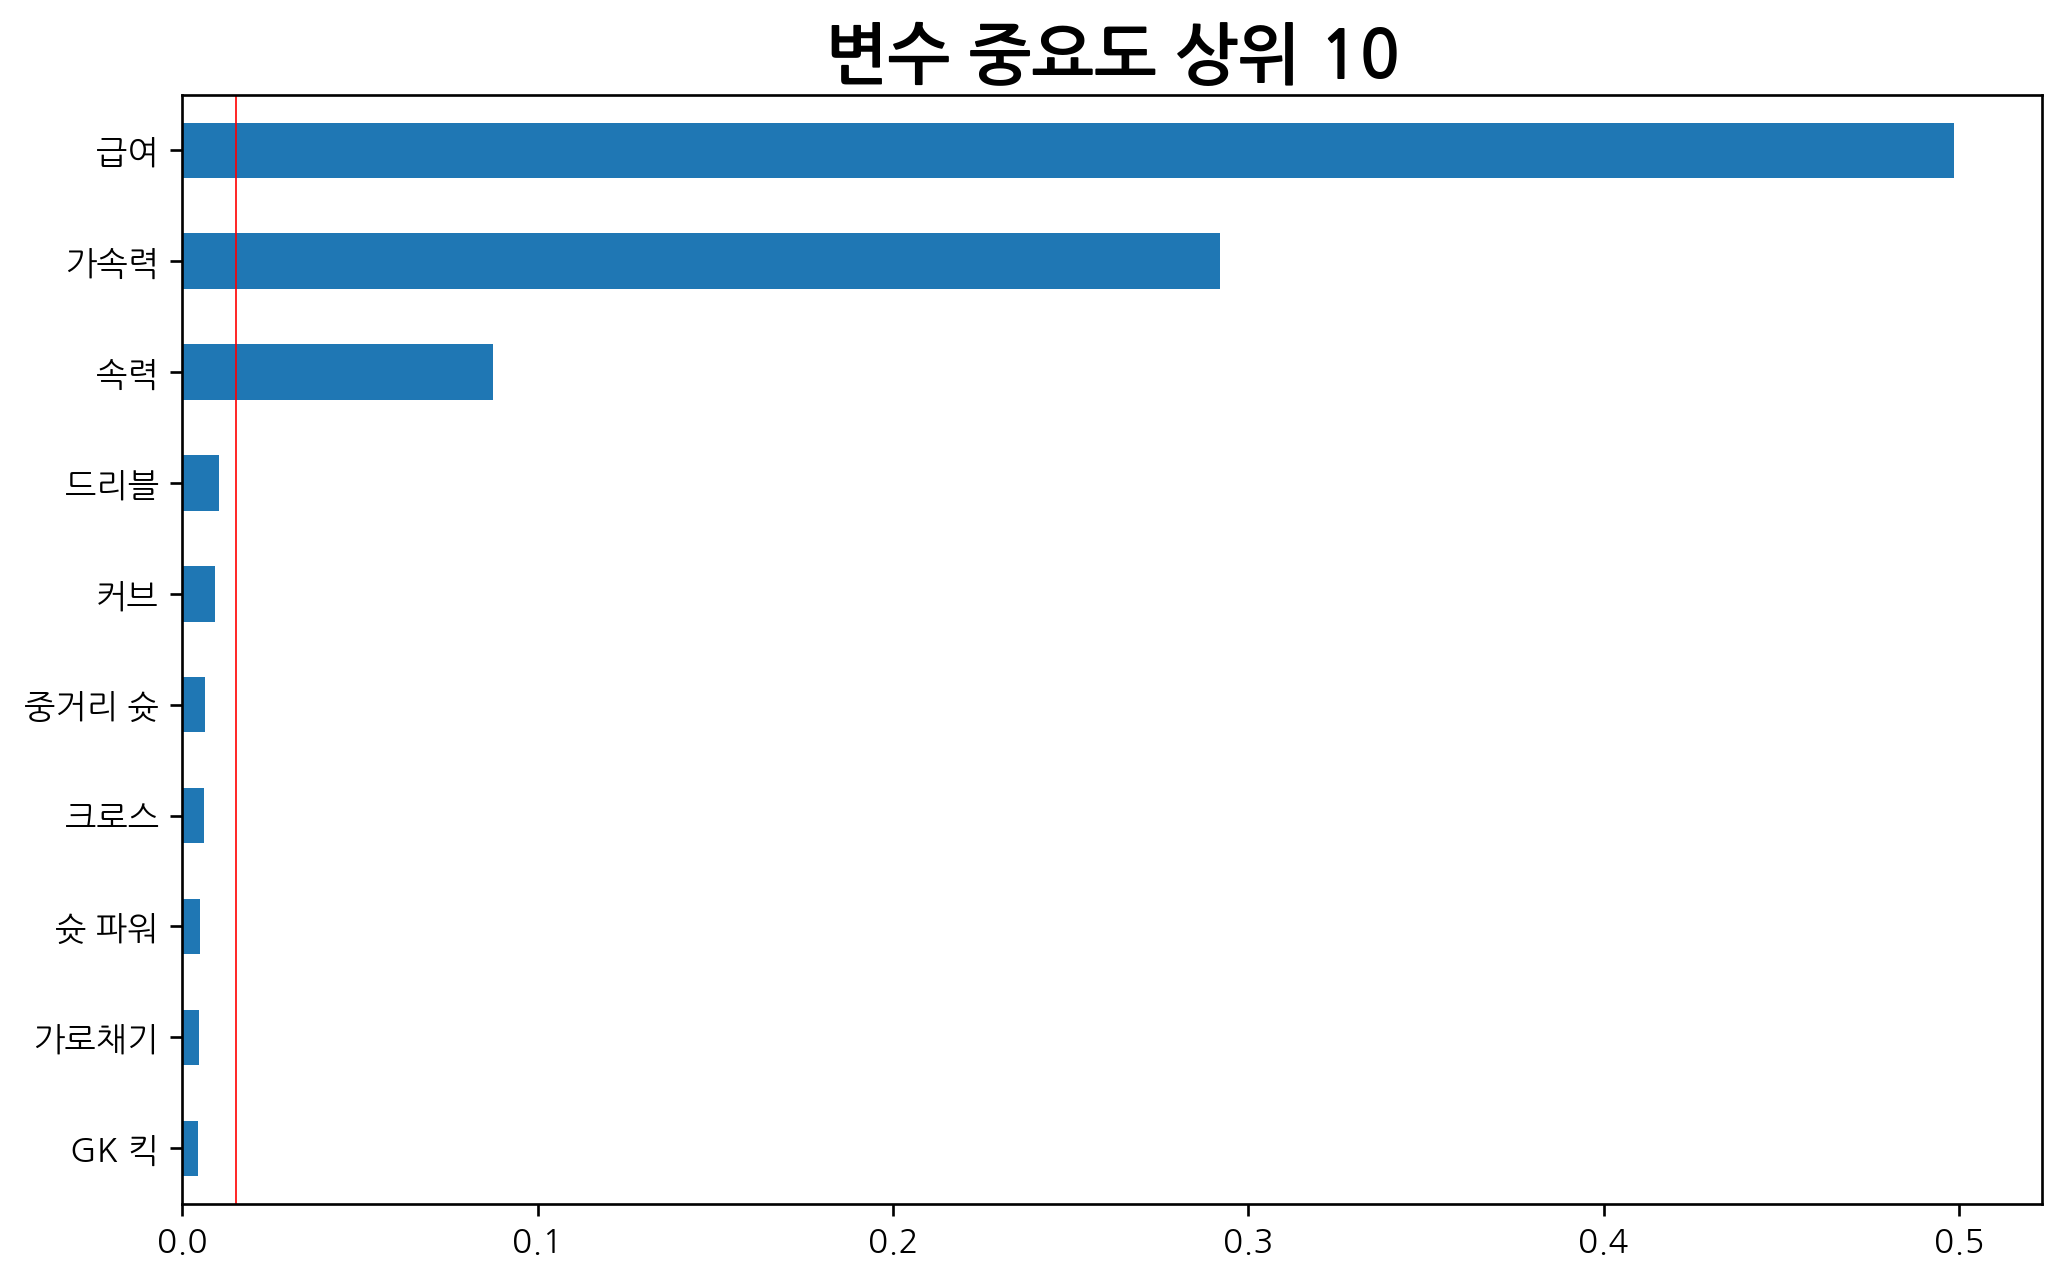

In [45]:
# 변수 중요도 시각화
feature_names = X_train.columns.tolist()
importances = pd.Series(final.feature_importances_, feature_names).sort_values()
importances = importances.tail(10)
plt.figure(figsize=(10, 6), dpi=120)
importances.plot.barh()
plt.axvline(0.015, color="red", linewidth=0.5)
plt.title("변수 중요도 상위 10", fontsize = 20, fontweight='bold')
plt.show()

In [117]:
y_pred = final.predict(X_test)

print("테스트 F1-Score : ", f1_score(y_test, y_pred))
print("테스트 Recall : ", recall_score(y_test, y_pred),'\n')

print(classification_report(y_test, y_pred))

테스트 F1-Score :  0.672
테스트 Recall :  0.7455621301775148 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3888
           1       0.61      0.75      0.67       169

    accuracy                           0.97      4057
   macro avg       0.80      0.86      0.83      4057
weighted avg       0.97      0.97      0.97      4057



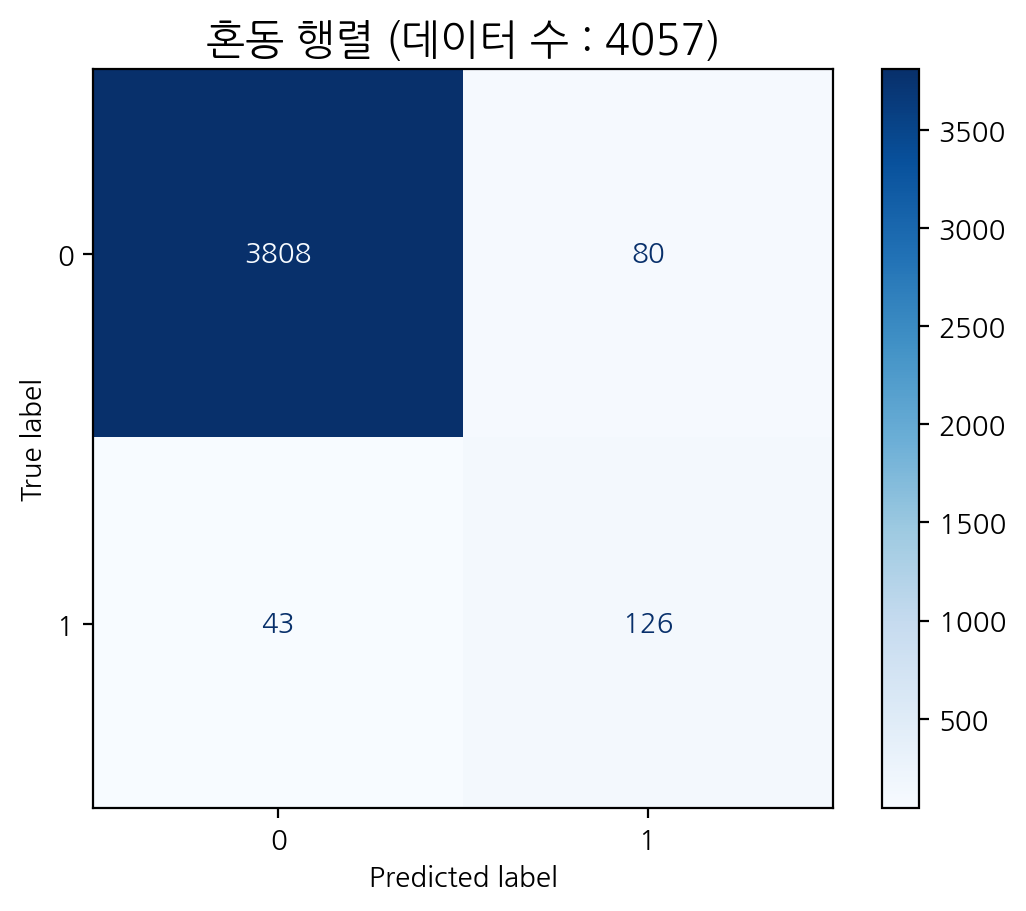

In [35]:
from sklearn.metrics import plot_confusion_matrix

# Confusion Matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(final, X_test, y_test,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'혼동 행렬 (데이터 수 : {len(y_test)})', fontsize=15)
plt.show()

In [25]:
y_base_pred_prob = base.predict_proba(X_test)[:,1]

In [27]:

base_fpr, base_tpr, thresholds = roc_curve(y_test, y_base_pred_prob)

base_roc = pd.DataFrame({
    'FPR(Fall-out)': base_fpr, 
    'TPR(Recall)': base_tpr, 
    'Threshold': thresholds
})

In [28]:
y_pred_prob = final.predict_proba(X_test)[:,1]

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPR(Recall)': tpr, 
    'Threshold': thresholds
})

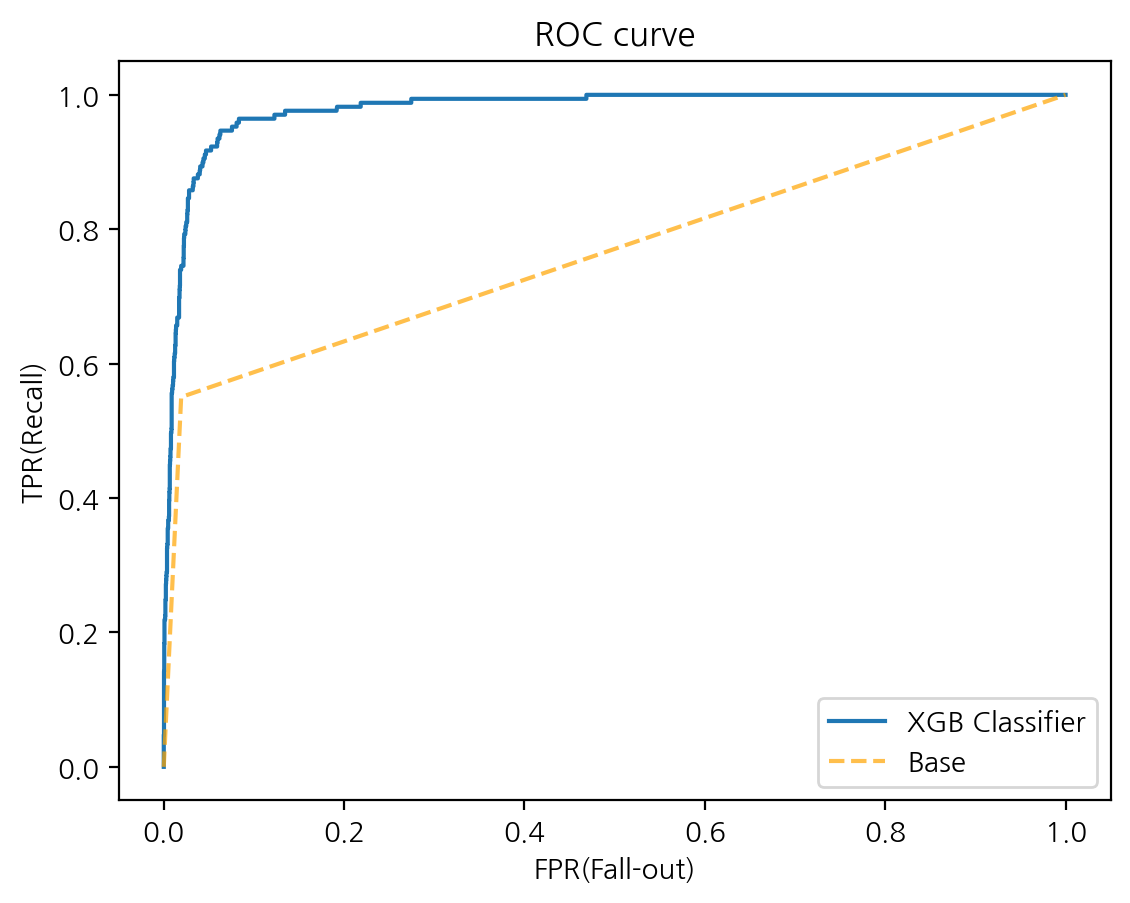

In [33]:
# ROC Curve

plt.plot(fpr, tpr, label='XGB Classifier')
plt.plot(base_fpr, base_tpr, linestyle='--', color = 'orange', alpha=0.7, label='Base')
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.legend();

In [36]:
# auc_score 
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_prob)
print(f"최종 모델의 auc score : {auc.round(2)}")

최종 모델의 auc score : 0.98
